In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from env import MPSPEnv

env = MPSPEnv(3, 3, 3)
observation_space = env.observation_space[0].shape[0]**2 + \
    env.observation_space[1].shape[0]**2

# env = gym.make('CartPole-v1')
# observation_space = env.observation_space.shape[0]

action_space = env.action_space.n

EPISODES = 100
LEARNING_RATE = 0.0001
MEM_SIZE = 10000
BATCH_SIZE = 64
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.001

FC1_DIMS = 1024
FC2_DIMS = 512
DEVICE = torch.device("cpu")


class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = observation_space
        self.action_space = action_space

        self.fc1 = nn.Linear(self.input_shape, FC1_DIMS)
        self.fc2 = nn.Linear(FC1_DIMS, FC2_DIMS)
        self.fc3 = nn.Linear(FC2_DIMS, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()
        self.to(DEVICE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0

        self.states = np.zeros((MEM_SIZE, observation_space), dtype=np.int64)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.int64)
        self.states_ = np.zeros((MEM_SIZE, observation_space), dtype=np.int64)
        self.dones = np.zeros(MEM_SIZE, dtype=bool)

    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE

        self.states[mem_index] = state
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_
        self.dones[mem_index] = 1 - done

        self.mem_count += 1

    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)

        states = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones = self.dones[batch_indices]

        return states, actions, rewards, states_, dones


class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network()

    def choose_action(self, observation, mask):
        if random.random() < self.exploration_rate:
            return env.action_space.sample(mask)

        state = torch.tensor(observation).float().detach()
        state = state.to(DEVICE)
        state = state.unsqueeze(0)
        q_values = self.network(state).detach()
        q_max = q_values.abs().max()
        masked_argmax = (
            q_values - 2 * q_max * (1 - mask)
        ).argmax()
        return masked_argmax.item()

    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return

        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states, dtype=torch.float32).to(DEVICE)
        actions = torch.tensor(actions, dtype=torch.long).to(DEVICE)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        states_ = torch.tensor(states_, dtype=torch.float32).to(DEVICE)
        dones = torch.tensor(dones, dtype=torch.bool).to(DEVICE)
        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)

        q_values = self.network(states)
        next_q_values = self.network(states_)

        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0]

        q_target = rewards + GAMMA * predicted_value_of_future * dones

        loss = self.network.loss(q_target, predicted_value_of_now)
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate


In [2]:
agent = DQN_Solver()

Episode 1 Average Reward -425.0 Best Reward 0 Last Reward 0 Epsilon 0.1588301139883539
Episode 2 Average Reward -212.5 Best Reward 0 Last Reward 0 Epsilon 0.1567776659433432
Episode 3 Average Reward -142.66666666666666 Best Reward 0 Last Reward -3 Epsilon 0.1533645326385287
Episode 4 Average Reward -107.0 Best Reward 0 Last Reward 0 Epsilon 0.1513827123949758
Episode 5 Average Reward -85.8 Best Reward 0 Last Reward -1 Epsilon 0.14972580367955157
Episode 6 Average Reward -71.5 Best Reward 0 Last Reward 0 Epsilon 0.14853218119844558
Episode 7 Average Reward -61.42857142857143 Best Reward 0 Last Reward -1 Epsilon 0.1461734072526738
Episode 8 Average Reward -53.75 Best Reward 0 Last Reward 0 Epsilon 0.14558959007955918
Episode 9 Average Reward -47.77777777777778 Best Reward 0 Last Reward 0 Epsilon 0.14457351523985087
Episode 10 Average Reward -43.3 Best Reward 0 Last Reward -3 Epsilon 0.1417093497873648
Episode 11 Average Reward -39.90909090909091 Best Reward 0 Last Reward -6 Epsilon 0.138

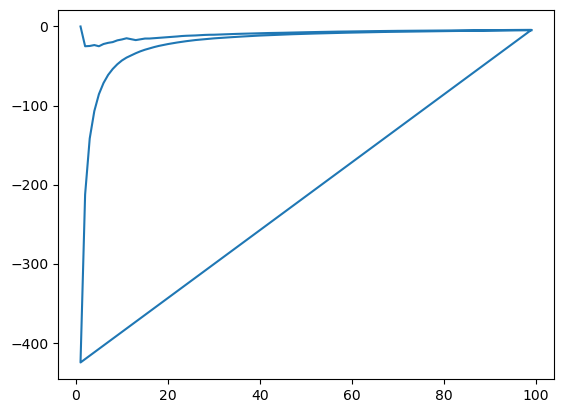

In [4]:
episode_number = []
episode_rewards = []

for i in range(1, EPISODES):
    state, info = env.reset()
    state = np.concatenate((state[0].flatten(), state[1].flatten()))
    score = 0

    while True:
        action = agent.choose_action(state, info['mask'])
        state_, reward, done, info = env.step(action)
        state_ = np.concatenate((state_[0].flatten(), state_[1].flatten()))
        agent.memory.add(state, action, reward, state_, done)
        agent.learn()
        state = state_
        score += reward

        if done:
            print(
                f'Episode {i} Reward {score} Epsilon {agent.returning_epsilon()}'
            )
            break

        episode_number.append(i)
        episode_rewards.append(score)

plt.plot(episode_number, episode_rewards)
plt.show()
